# LSTM implementation
<hr>
This notebook implements a LSTM model to predict a vector of outputs (Y) given an history of inputs (X).
<br><br>
<b id="tocheading">Table of Contents</b>
<hr>
<div id="toc"></div>


In [28]:
%%javascript
/* Generate Table of Contents */
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## 1. Initialisation

In [29]:
# reset variables and set global paths
%reset -f 
import os, sys

ROOT_PATH = os.path.abspath(".").split("src")[0]
if (os.path.join(ROOT_PATH, 'src') not in sys.path):
    sys.path.append(os.path.join(ROOT_PATH, 'src'))

In [30]:
# import essential libraries
import numpy as np
import pandas as pd
import datetime

# keras used for deep learning
import keras; print("keras.__version__ =", keras.__version__ )
from keras import layers, regularizers, Input, Model
from tensorflow.python.keras.initializers import RandomUniform
from keras.optimizers import RMSprop, Adam, Nadam
from keras.models import Sequential
from keras import backend as K

# tensorflow
import tensorflow as tf; print("tf.__version__ =", tf.__version__)
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# plotting
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

keras.__version__ = 2.2.4
tf.__version__ = 1.12.0


In [31]:
# configure matplotlib params and plotting
## use seaborn as this gives nicer plots than the standard 
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

rc('figure', figsize=(12,6))
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('axes', labelsize=13, titlesize=14)
rc('legend', fontsize=14, handlelength=2)

# set seeds for reproducibility
SEED=100
np.random.seed(SEED)
tf.set_random_seed(SEED)

## 2. Data loading
<hr> 
Load data from pre-stored files

In [32]:
DATA_PATH = ROOT_PATH + "data/project-thesis/"
num_obs = 6000  # 6000, 20000 or 50000; number of observations to use

df2np = np.load(DATA_PATH + "dummy_data/dummy_complete_{}.npy".format(num_obs))
df2np_train = np.load(DATA_PATH + "dummy_data/dummy_train_{}.npy".format(num_obs))
df2np_valid = np.load(DATA_PATH + "dummy_data/dummy_valid_{}.npy".format(num_obs))
df2np_test = np.load(DATA_PATH + "dummy_data/dummy_test_{}.npy".format(num_obs))

train_size = df2np_train.shape[0]
valid_size = df2np_valid.shape[0]
test_size = df2np_test.shape[0]

print("Training set size:   \t", train_size)
print("Validation set size: \t", valid_size)
print("Testing set size:    \t", test_size)

# read metadata
feature_tags = list(np.load(DATA_PATH + "metadata/feature_tags.npy"))
target_tags = list(np.load(DATA_PATH + "metadata/target_tags.npy"))
headers = feature_tags + target_tags

means = np.load(DATA_PATH + "metadata/means.npy")
stds = np.load(DATA_PATH + "metadata/stds.npy")

Training set size:   	 3600
Validation set size: 	 1200
Testing set size:    	 1200


In [33]:
# only use one of the outputs
delay = 0 # do not lag the data at all
lookback=100 # use the 100 previous observations in each batch
batch_size=128 # use 128 observations in each batch

inputs_idxs = np.array(range(len(feature_tags)))
#outputs_idxs = np.array(range(len(feature_tags), len(headers)))
outputs_idxs = np.array([6,7,8])

x_train = df2np_train[:,inputs_idxs]
y_train = df2np_train[:,outputs_idxs]

x_valid = df2np_valid[:,inputs_idxs]
y_valid = df2np_valid[:,outputs_idxs]

x_test = df2np_test[:-delay,inputs_idxs]
y_test = df2np_test[delay:,outputs_idxs]

print(x_train.shape, y_train.shape)
assert x_train.shape[0] == y_train.shape[0] and x_train.shape[1]==len(feature_tags) and y_train.shape[1]==len(outputs_idxs)

(3600, 6) (3600, 3)


### Plots
Try and plot the data to get a feel for it

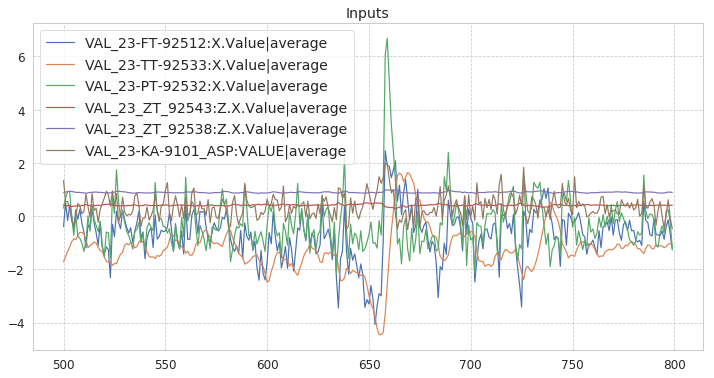

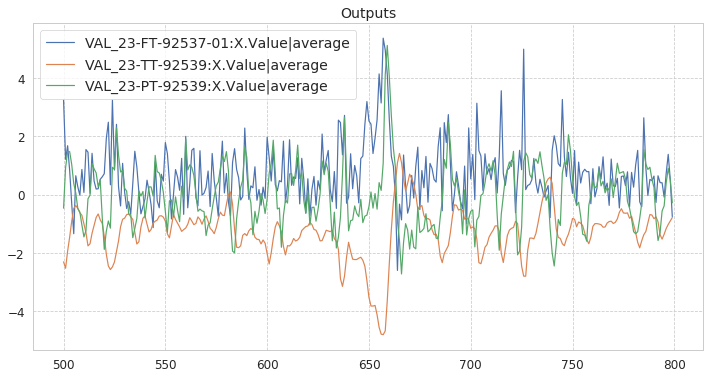

In [34]:
plot_from = 500
number_of_steps = 300
plot_to=plot_from+number_of_steps

plt.figure()
for signal in range(len(feature_tags)):
    plt.plot(range(plot_from, plot_to), df2np_train[plot_from:plot_to,signal], label=feature_tags[signal])
plt.title("Inputs")
plt.legend(frameon=True)
plt.show()

plt.figure()
i=0
for signal in outputs_idxs:
    plt.plot(range(plot_from, plot_to), df2np_train[plot_from:plot_to,signal], label=target_tags[i])
    i+=1;

plt.title("Outputs")
plt.legend(frameon=True)
plt.show()

<hr>

## 3. Defining a Generator

<hr/>
Define a generator to generate batches of data such that the models don't have to read everything at once. 

### Definition

In [35]:
def batch_generator(x_data, y_data, lookback, batch_size=128):
    """
    Generator function for creating random batches of training-data.
    
    :param x_data: Numpy array of the features, not targets. 2D array, normalized/scaled, numpy.
    :param y_data: Numpy array of the targets, not features. 2D array, normalized/scaled, numpy. 
    :param lookback: How many timesteps back the input data should go.
    :param batch_size: The number of samples per batch.
    """
    num_x_signals = x_data.shape[1]
    num_y_signals = y_data.shape[1]

    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, lookback, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, lookback, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(x_data.shape[0] - lookback)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_data[idx:idx+lookback]
            y_batch[i] = y_data[idx:idx+lookback]
        
        yield (x_batch, y_batch)

In [36]:
train_gen = batch_generator(x_train, y_train, lookback, batch_size)
samples,targets=next(train_gen)
print(samples.shape, targets.shape)

(128, 100, 6) (128, 100, 3)


In [37]:
def choose_generator_steps(data, lookback, delay, batch_size):
    """
    Function to choose the maximum number of generator steps such that the generator
    doesn't overflow the number of observations
    """
    return ((len(data) - lookback - delay - (batch_size-1)) // batch_size) + 1

## 4. Model implementation
---

In [38]:
def plot_history(history, savepath=None):
    """
    Plots the training and validation loss history of the model in the training phase. 
    """
    epochs = history.epoch

    train_mae = history.history['loss']
    val_mae = history.history['val_loss']

    plt.figure()
    plt.plot(epochs, train_mae, marker='o', markersize='3.0', label=r'Training loss', color="darkred")
    plt.plot(epochs, val_mae, marker='o', markersize='3.0', label=r'Validation loss', color="darkblue")  
    plt.xlabel(r'Epoch')
    plt.ylabel(r'MAE')
    plt.legend(frameon=True)
    if savepath is not None: 
        plt.savefig(savepath)
    plt.show()

### Defining the architecture

In [39]:
def build_model(input_layer, num_output_signals):  
    layer_1 = layers.GRU(128,
                         dropout = 0.2,
                         recurrent_dropout = 0.2,
                         return_sequences=True,
                         kernel_initializer = 'glorot_normal')(input_layer)
    
    init = RandomUniform(minval=-0.05, maxval=0.05)
    output_layer = layers.Dense(num_output_signals, kernel_initializer=init)(layer_1)
    
    model = Model(input_layer, output_layer) 
    return model

### Training the model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 6)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, None, 128)         51840     
_________________________________________________________________
dense_1 (Dense)              (None, None, 3)           387       
Total params: 52,227
Trainable params: 52,227
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
26/26 [==============================] - 5s 188ms/step - loss: 0.6517 - val_loss: 0.7946
Epoch 2/10
26/26 [==============================] - 5s 174ms/step - loss: 0.4795 - val_loss: 0.6711
Epoch 3/10
26/26 [==============================] - 4s 173ms/step - loss: 0.3838 - val_loss: 0.6838
Epoch 4/10
26/26 [==============================] - 4s 172ms/step - loss: 0.3486 - val_loss: 0.6677
Ep

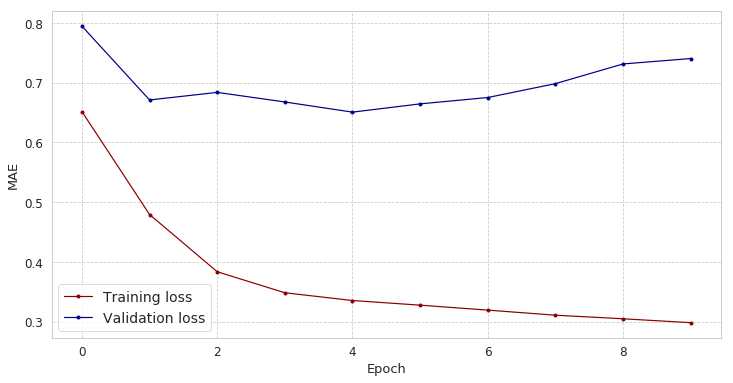

In [40]:
# Defining variables 
batch_size=128
lookback=200
delay=0
epochs=10


# train the model
#####train_steps = x_train.shape[0] // batch_size
#####valid_steps = len(x_valid) // batch_size
train_gen = batch_generator(x_train, y_train, lookback, batch_size)
valid_gen = batch_generator(x_valid, y_valid, lookback, batch_size)

train_steps = (len(x_train) - lookback) // batch_size
valid_steps = (len(x_valid) - lookback) // batch_size

# Train the model
K.clear_session()
input_layer = Input(shape=(None,x_train.shape[-1]))
model = build_model(input_layer, y_train.shape[-1])
model.compile(loss='MAE', optimizer='ADAM')
model.summary()

history = model.fit_generator(generator=train_gen,
                              epochs=epochs,
                              steps_per_epoch=train_steps,
                              validation_data=valid_gen,
                              validation_steps=valid_steps)

plot_history(history)

## 5. Results

In [41]:
def MAE(targets, predictions, vector=False):
    """
    Calculates the mean absolute error between vectors/matrices
    
    :param targets: a matrix/vector of true targets
    :param predictions: a matrix/vector of predictions
    :param vector: boolean stating if a vector of MAEs should be returned in the case where the targets/predictions are matrices.
    """
    if vector:
        return np.mean(np.abs(targets - predictions), axis=0)
    else:
        return np.mean(np.abs(targets - predictions))

def make_prediction(model, x_data, y_data):
    
    # expand inputs to right dimension
    x = x_data
    if len(x_data.shape) == 1:
        x = np.expand_dims(x_data, axis=0)
    x = np.expand_dims(x,axis=0)
    
    # make predictions
    preds = model.predict(x)[0]
    true = y_data
    
    if len(true.shape) == 1:
        true = np.expand_dims(y_data,axis=0)
    
    return true, preds

def plot_prediction(model, x_data, y_data, plot_from, plot_length):
    plot_to = plot_from + plot_length
    
    true, preds = make_prediction(model, x_data, y_data)
    
    for feature in range(y_data.shape[-1]):
        plt.figure()
        plt.title(feature_tags[feature])
        plt.plot(true[plot_from:plot_to,feature], c="darkred", label="true")
        plt.plot(preds[plot_from:plot_to,feature], c="darkblue", label="predictions")
        plt.legend(frameon=True)
        plt.show()
        
def evaluate_model(model, x_data, y_data):
    true, preds = make_prediction(model, x_data, y_data)
    return MAE(true, preds, vector=True)
    

MAE = [0.60688296 1.31464302 0.3285145 ]


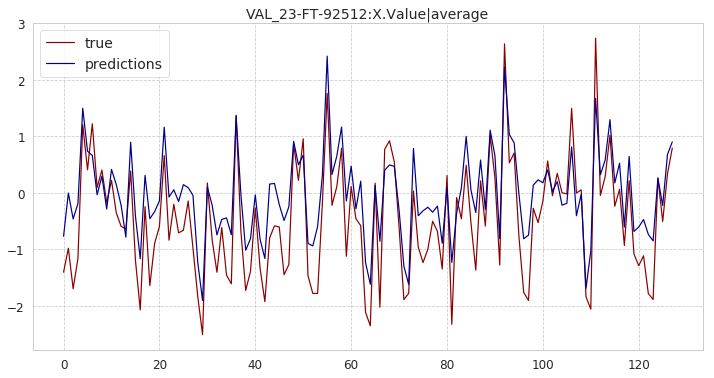

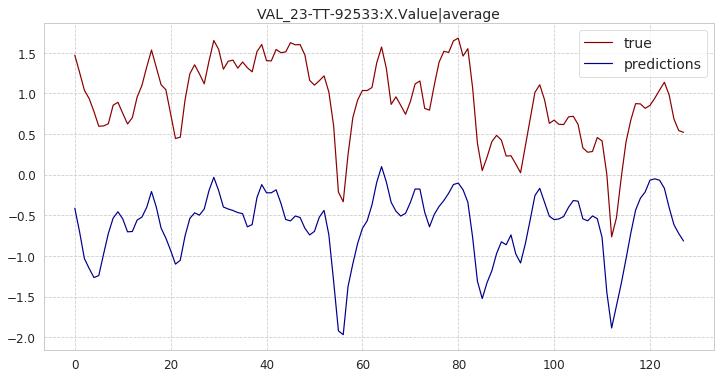

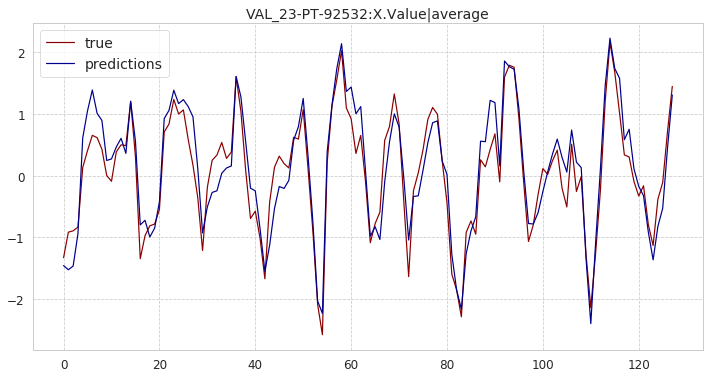

In [42]:
print("MAE = {0}".format(evaluate_model(model, x_valid, y_valid)))
plot_prediction(model, x_valid, y_valid, 0+lookback, 128)